# Extended Kalman filter for Nomoto model
An Extended Kalman filter with a Nomoto model as the predictor will be developed.
The filter is run on simulated data as well as real model test data.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import sympy as sp

import src.visualization.book_format as book_format
book_format.set_style()
from src.substitute_dynamic_symbols import lambdify
from sympy import Matrix
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify
from sympy.physics.vector.printing import vpprint, vlatex
from src.data import mdl
from src.kalman_filter import extended_kalman_filter

## Nomoto model for ship manoeuvring dynamics
The Nomoto model can be written as:

In [2]:
r,r1d,r2d = sp.symbols('r \dot{r} \ddot{r}')
psi,psi1d = sp.symbols('psi \dot{\psi}')
h,u = sp.symbols('h u')
x, x1d = sp.symbols('x \dot{x}')
A,B,C,D,E, Phi = sp.symbols('A B C D E Phi')
w = sp.symbols('w')

K, delta, T_1, T_2 = sp.symbols('K delta T_1 T_2')

eq_nomoto = sp.Eq(K*delta,
                 r + T_1*r1d + T_2*r2d)
Math(vlatex(eq_nomoto))

<IPython.core.display.Math object>

where $r$ is yaw rate with its time derivatives and $\delta$ is the rudder angle. $K$, $T_{1}$
 and $T_{1}$ are the coefficients describing the hydrodynamics of the ship.
 
For slow manoeuvres this equation can be further simplified by removing the $\ddot{r}$ term into a first order Nomoto model:

In [3]:
eq_nomoto_simple = eq_nomoto.subs(r2d,0)
Math(vlatex(eq_nomoto_simple))

<IPython.core.display.Math object>

### Simulation model

In [4]:
f_hat = sp.Function('\hat{f}')(x,u,w)
eq_system = sp.Eq(x1d, f_hat)
eq_system

Eq(\dot{x}, \hat{f}(x, u, w))

Where the state vector $x$:

In [5]:
eq_x = sp.Eq(x, sp.UnevaluatedExpr(Matrix([psi,r])))
eq_x

Eq(x, Matrix([
[psi],
[  r]]))

and input vector $u$:

and $w$ is zero mean Gausian process noise

For the nomoto model the time derivatives for the states can be expressed as:

In [6]:
eq_psi1d = sp.Eq(psi1d,r)
eq_psi1d

Eq(\dot{\psi}, r)

In [7]:
eq_r1d = sp.Eq(r1d,sp.solve(eq_nomoto_simple,r1d)[0])
eq_r1d

Eq(\dot{r}, (K*delta - r)/T_1)

In [8]:
def lambda_f_constructor(K, T_1):
    def lambda_f(x, u):
        delta = u
        f = np.array([[x[1], (K*delta-x[1])/T_1]]).T
        return f

    return lambda_f

In [9]:
jac = sp.eye(2,2) + Matrix([r,eq_r1d.rhs]).jacobian([psi,r])*h
jac

Matrix([
[1,         h],
[0, 1 - h/T_1]])

In [10]:
Matrix([r,
       eq_r1d.rhs]).jacobian([delta])

Matrix([
[    0],
[K/T_1]])

In [11]:
def lambda_jacobian_constructor(h,T_1):
    def lambda_jacobian(x, u):

        jac = np.array(
            [
                [1, h],
                [0, 1-h/T_1],
                
            ]
        )
        return jac

    return lambda_jacobian

## Simulation
Simulation with this model where rudder angle shifting between port and starboard

In [12]:
T_1_ = 1.8962353076056344
K_ = 0.17950970687951323
h_ = 0.02

lambda_f = lambda_f_constructor(K=K_, T_1=T_1_)
lambda_jacobian = lambda_jacobian_constructor(h=h_, T_1=T_1_)

In [13]:
def simulate(E, ws, t, us):
    
    simdata = []
    x_=np.deg2rad(np.array([[0,0]]).T)
    
    for u_,w_ in zip(us,ws):
               
        x_=x_ + h_*lambda_f(x=x_.flatten(), u=u_)
    
        simdata.append(x_.flatten())
        
    simdata = np.array(simdata)
    df = pd.DataFrame(simdata, columns=["psi","r"], index=t)
    df['delta'] = us
    
    return df

In [14]:
N_ = 4000

t_ = np.arange(0,N_*h_,h_)
    
us = np.deg2rad(np.concatenate((-10*np.ones(int(N_/4)),
                                10*np.ones(int(N_/4)),
                                -10*np.ones(int(N_/4)),
                                10*np.ones(int(N_/4)))))

np.random.seed(42)
E = np.array([[0, 1]]).T
process_noise = np.deg2rad(0.01)
ws = process_noise*np.random.normal(size=N_)
df = simulate(E=E, ws=ws, t=t_, us=us)

measurement_noise = np.deg2rad(0.5)
df['epsilon'] = measurement_noise*np.random.normal(size=N_)
df['psi_measure'] = df['psi'] + df['epsilon']
df['psi_deg'] = np.rad2deg(df['psi'])
df['psi_measure_deg'] = np.rad2deg(df['psi_measure'])
df['delta_deg'] = np.rad2deg(df['delta'])


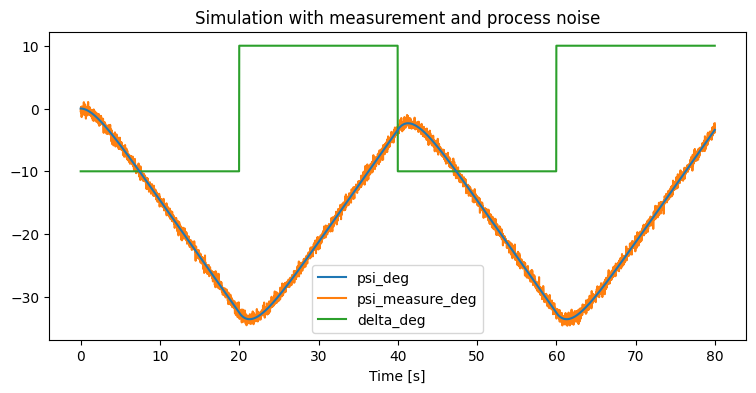

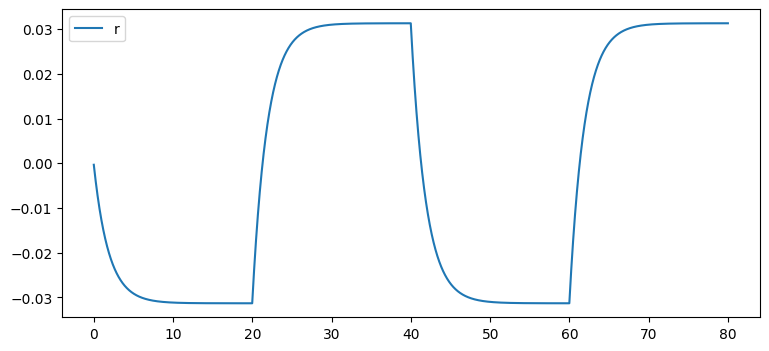

In [15]:
fig,ax=plt.subplots()
df.plot(y='psi_deg', ax=ax)
df.plot(y='psi_measure_deg', ax=ax, zorder=-1)
df.plot(y='delta_deg', ax=ax, zorder=-1)
df.plot(y='r')
ax.set_title('Simulation with measurement and process noise')
ax.set_xlabel('Time [s]');



## Kalman filter
Implementation of the Kalman filter. The code is inspired of this Matlab implementation: [ExEKF.m](https://github.com/cybergalactic/MSS/blob/master/mssExamples/ExEKF.m).

In [16]:
x0=np.deg2rad(np.array([[0,0]]).T)
P_prd = np.diag(np.deg2rad([1, 0.1]))

Qd = np.deg2rad(np.diag([0, 0.5]))

Rd = np.deg2rad(1)

ys = df['psi_measure'].values

E_ = np.array(
    [[0,0], [0,1]],
)

C_ = np.array([[1, 0]])

Cd_ = C_
Ed_ = h_ * E_

time_steps = extended_kalman_filter(x0=x0, P_prd=P_prd, lambda_f=lambda_f, 
                                    lambda_jacobian=lambda_jacobian,h=h_, us=us, ys=ys, E=E_, Qd=Qd, Rd=Rd, Cd=Cd_)
x_hats = np.array([time_step["x_hat"] for time_step in time_steps]).T
time = np.array([time_step["time"] for time_step in time_steps]).T
Ks = np.array([time_step["K"] for time_step in time_steps]).T


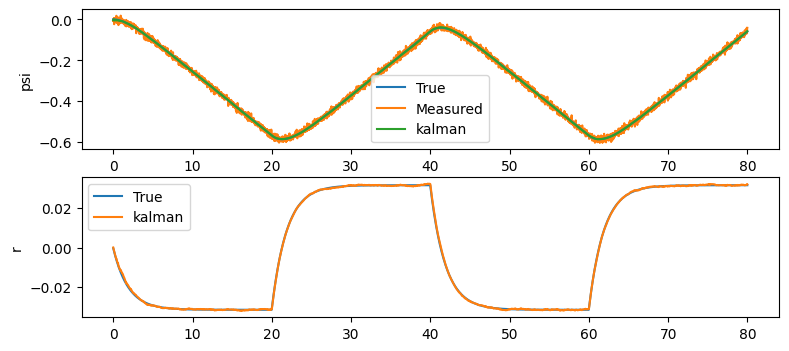

In [17]:
n=len(P_prd)
fig,axes=plt.subplots(nrows=n)

keys = ['psi','r']
for i,key in enumerate(keys):
    
    ax=axes[i]
    df.plot(y=key, ax=ax, label="True")
    if key=='psi':
        df.plot(y='psi_measure', ax=ax, label="Measured", zorder=-1)
    
    ax.plot(time, x_hats[i, :], "-", label="kalman")
    ax.set_ylabel(key)
    ax.legend()

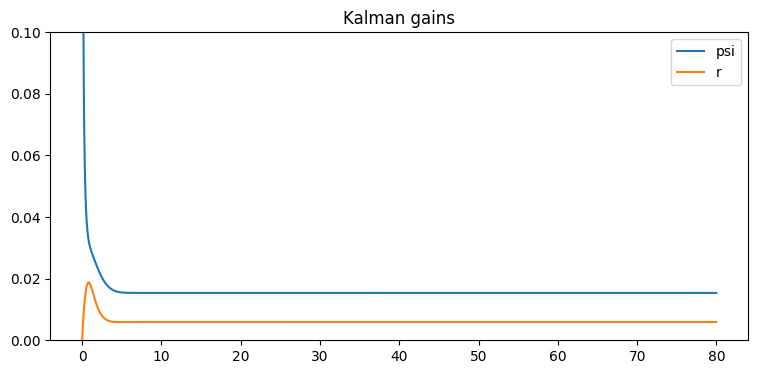

In [18]:
fig,ax=plt.subplots()
for i,key in enumerate(keys):
    ax.plot(time,Ks[i,:],label=key)
ax.set_title('Kalman gains')
ax.legend();
ax.set_ylim(0,0.1);


# Real data
Using the developed Kalman filter on some real model test data

## Load test

In [19]:
id=22773
df, units, meta_data = mdl.load(dir_path = '../data/raw', id=id)
df.index = df.index.total_seconds()
df.index-=df.index[0]

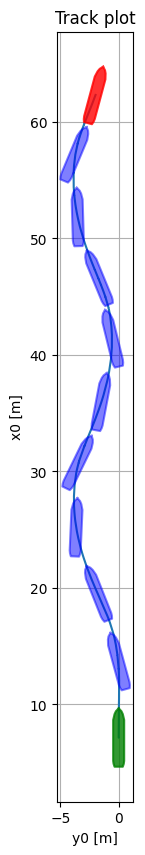

In [20]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

In [21]:
ys = df['psi'].values
h_m=h_ = df.index[1]-df.index[0]
x0=np.deg2rad(np.array([[0,0]]).T)
us = df['delta'].values

P_prd = np.diag(np.deg2rad([1, 0.1]))
Qd = np.deg2rad(np.diag([0, 5]))
Rd = np.deg2rad(0.1)

time_steps = extended_kalman_filter(x0=x0, P_prd=P_prd, lambda_f=lambda_f, 
                                    lambda_jacobian=lambda_jacobian,h=h_, us=us, ys=ys, E=E_, Qd=Qd, Rd=Rd, Cd=Cd_)
x_hats = np.array([time_step["x_hat"] for time_step in time_steps]).T
time = np.array([time_step["time"] for time_step in time_steps]).T
Ks = np.array([time_step["K"] for time_step in time_steps]).T

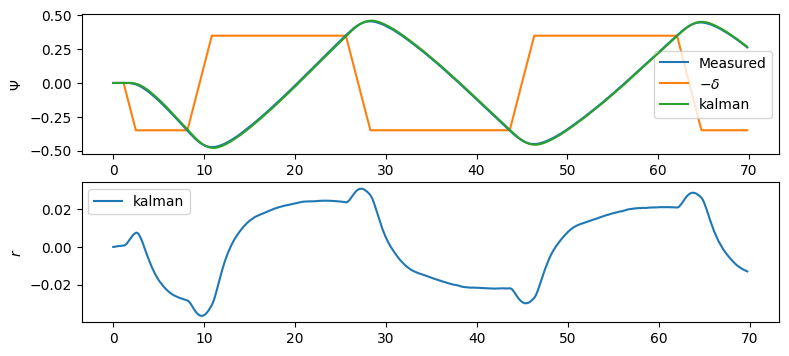

In [22]:
n=len(P_prd)
fig,axes=plt.subplots(nrows=n)

    
ax=axes[0]
df.plot(y='psi', ax=ax, label="Measured", zorder=-1)
df['-delta']=-df['delta']
df.plot(y='-delta', ax=ax, label='$-\delta$', zorder=-10)
ax.plot(time, x_hats[0, :], "-", label="kalman", zorder=10)
ax.set_ylabel('$\Psi$')
ax.legend()

ax=axes[1]
ax.plot(time, x_hats[1, :], "-", label="kalman")
ax.set_ylabel('$r$')

ax.legend();